In [42]:
using MLDatasets
using Distances,SpectralClustering, Plots, Clustering
using Munkres
using Statistics
using MLBase

In [43]:
function make_cost_matrix(labels, classes)
    
    uc1 = sort(unique(labels))
    uc2 = sort(unique(classes))
    l1 = length(uc1)
    l2 = length(uc2)
    

    m = ones(l1, l2)
    for i=1:l1
        it_i = findall(labels .== uc1[i])
        for j=1:l2
            it_j = findall(classes .== uc2[j])
            m_ij =  intersect(it_j, it_i)
            m[i,j] =  -length(m_ij)
        end
    end
    return m
end
function relabel(predicted::Vector{<:Integer},ground_truth::Vector{<:Integer})
    s = make_cost_matrix(predicted, ground_truth)
    predicted_1 = copy(predicted)
    for (source, target) in enumerate(munkres(s))
        predicted_1[predicted.==source] .= target
    end
    return predicted_1
end

relabel (generic function with 1 method)

## Load data

In [44]:
train_x, train_y = MNIST(split=:train)[:]
train_y .+= 1
N = 10000
train_x = float.(reshape(train_x, (28*28, 60000)))
train_x = train_x[:, begin:N];
train_y = train_y[begin:N];

## Build the graph

In [45]:
knnconfig = KNNNeighborhood(train_x, 50)
function weight(i::Integer, neigh, v, m)
    return exp.(-Distances.colwise(SqEuclidean(), m, v) / 100)
end

graph = create(knnconfig, weight, train_x);
knnconfig = nothing

## Clusterize

In [46]:
pred_clustering_1 = clusterize(NgLaplacian(10), KMeansClusterizer(10), graph)
pred_clustering_1 = relabel(pred_clustering_1.assignments, train_y);

In [47]:
C = confusmat(10, train_y, pred_clustering_1)

10×10 Matrix{Int64}:
 955    1    3    3    3    7   27    0    2    0
   0  598    2    1    1  520    0    1    1    3
   9   80  774   17   10   65    6   14    9    7
   3   10    7  901   17   41    5   16   26    6
   0   28    2    0  516   16    7    1    0  410
   6    1    1  385   28  407   26    0    7    2
   9    5    0    5    5   17  973    0    0    0
   0   37    2    0   96   18    0  855    0   62
   7   28    5  207   18   43   16    3  574   43
   3    4    2   18  470    6    3   18    1  453

In [48]:
correctrate(train_y, pred_clustering_1)

0.7006

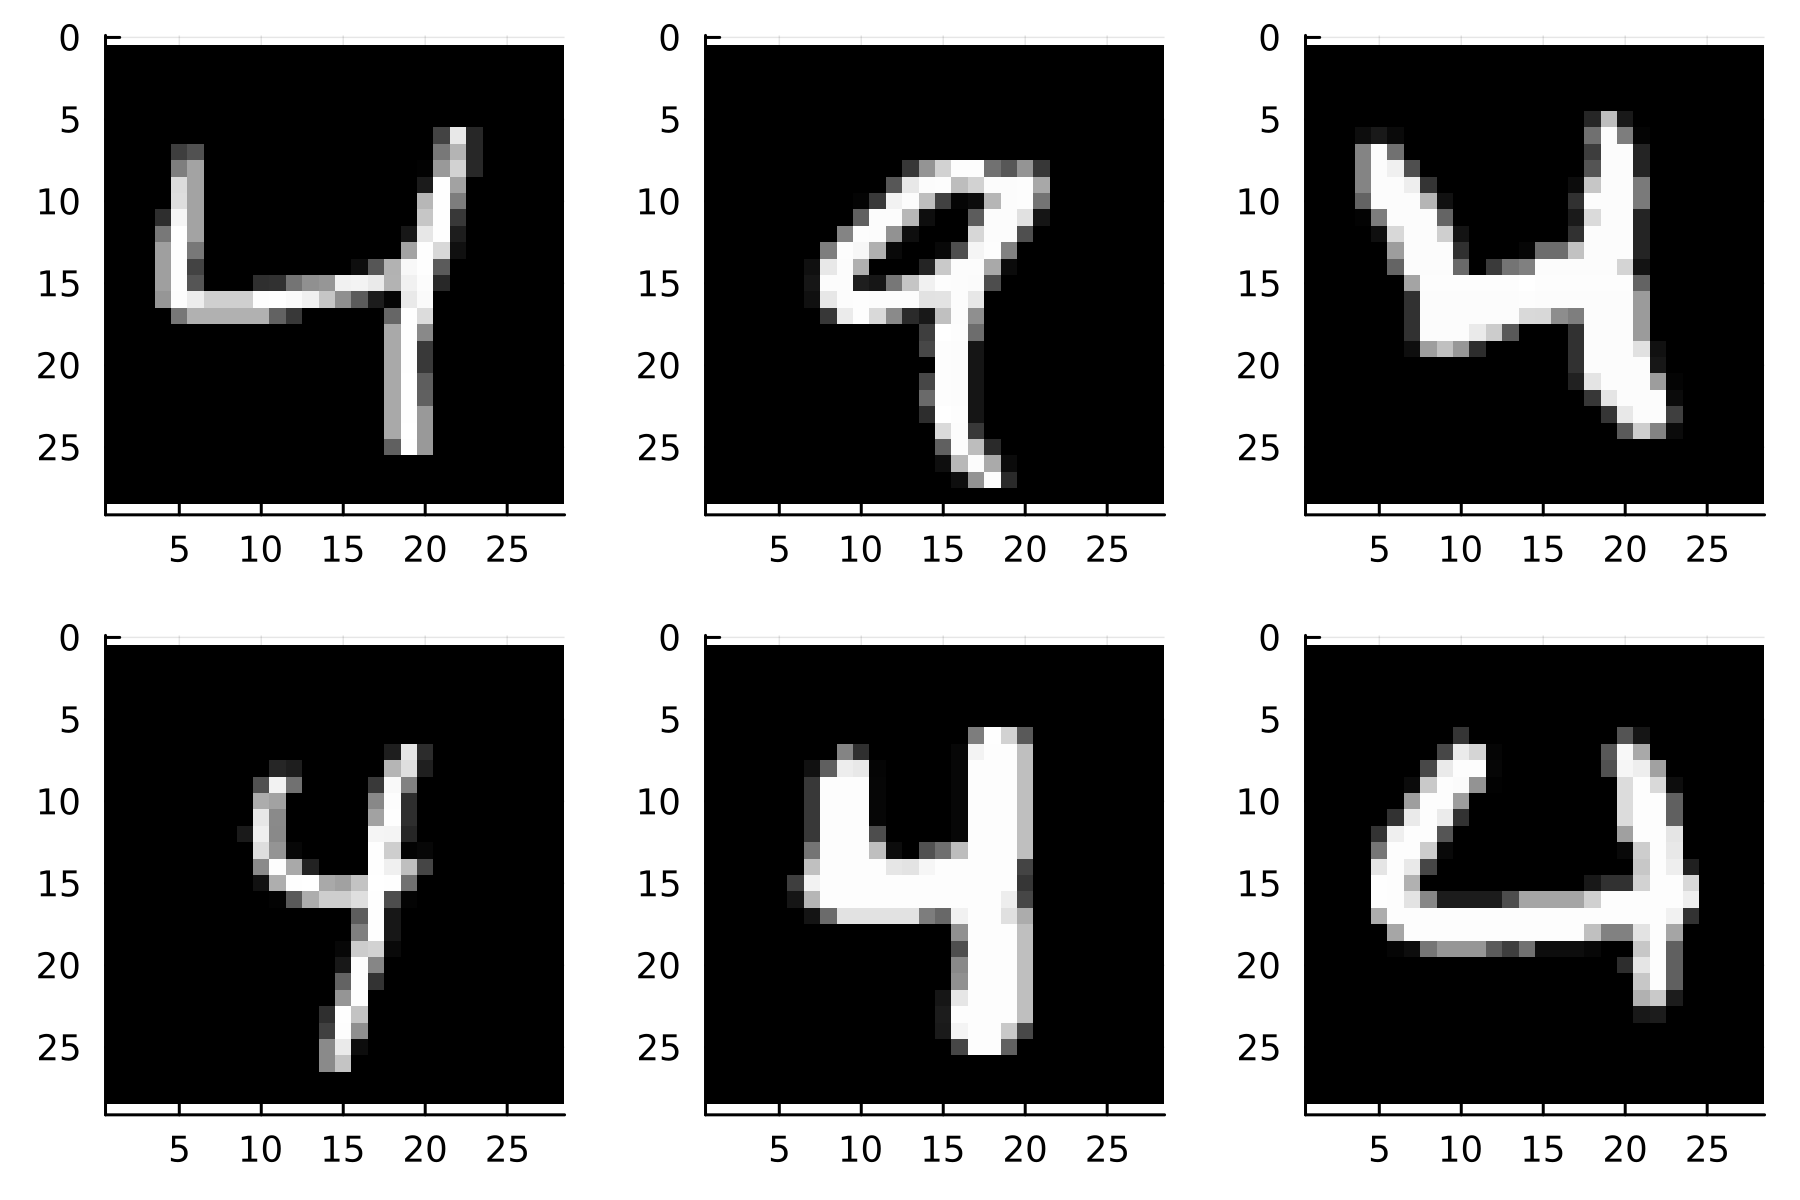

In [49]:
pred = findall(pred_clustering_1 .== (4 + 1))
plt = nothing
images = [plot(Gray.(reshape(train_x[:,pred[i]], 28, 28)')) for i=1:6]
plot(images...)

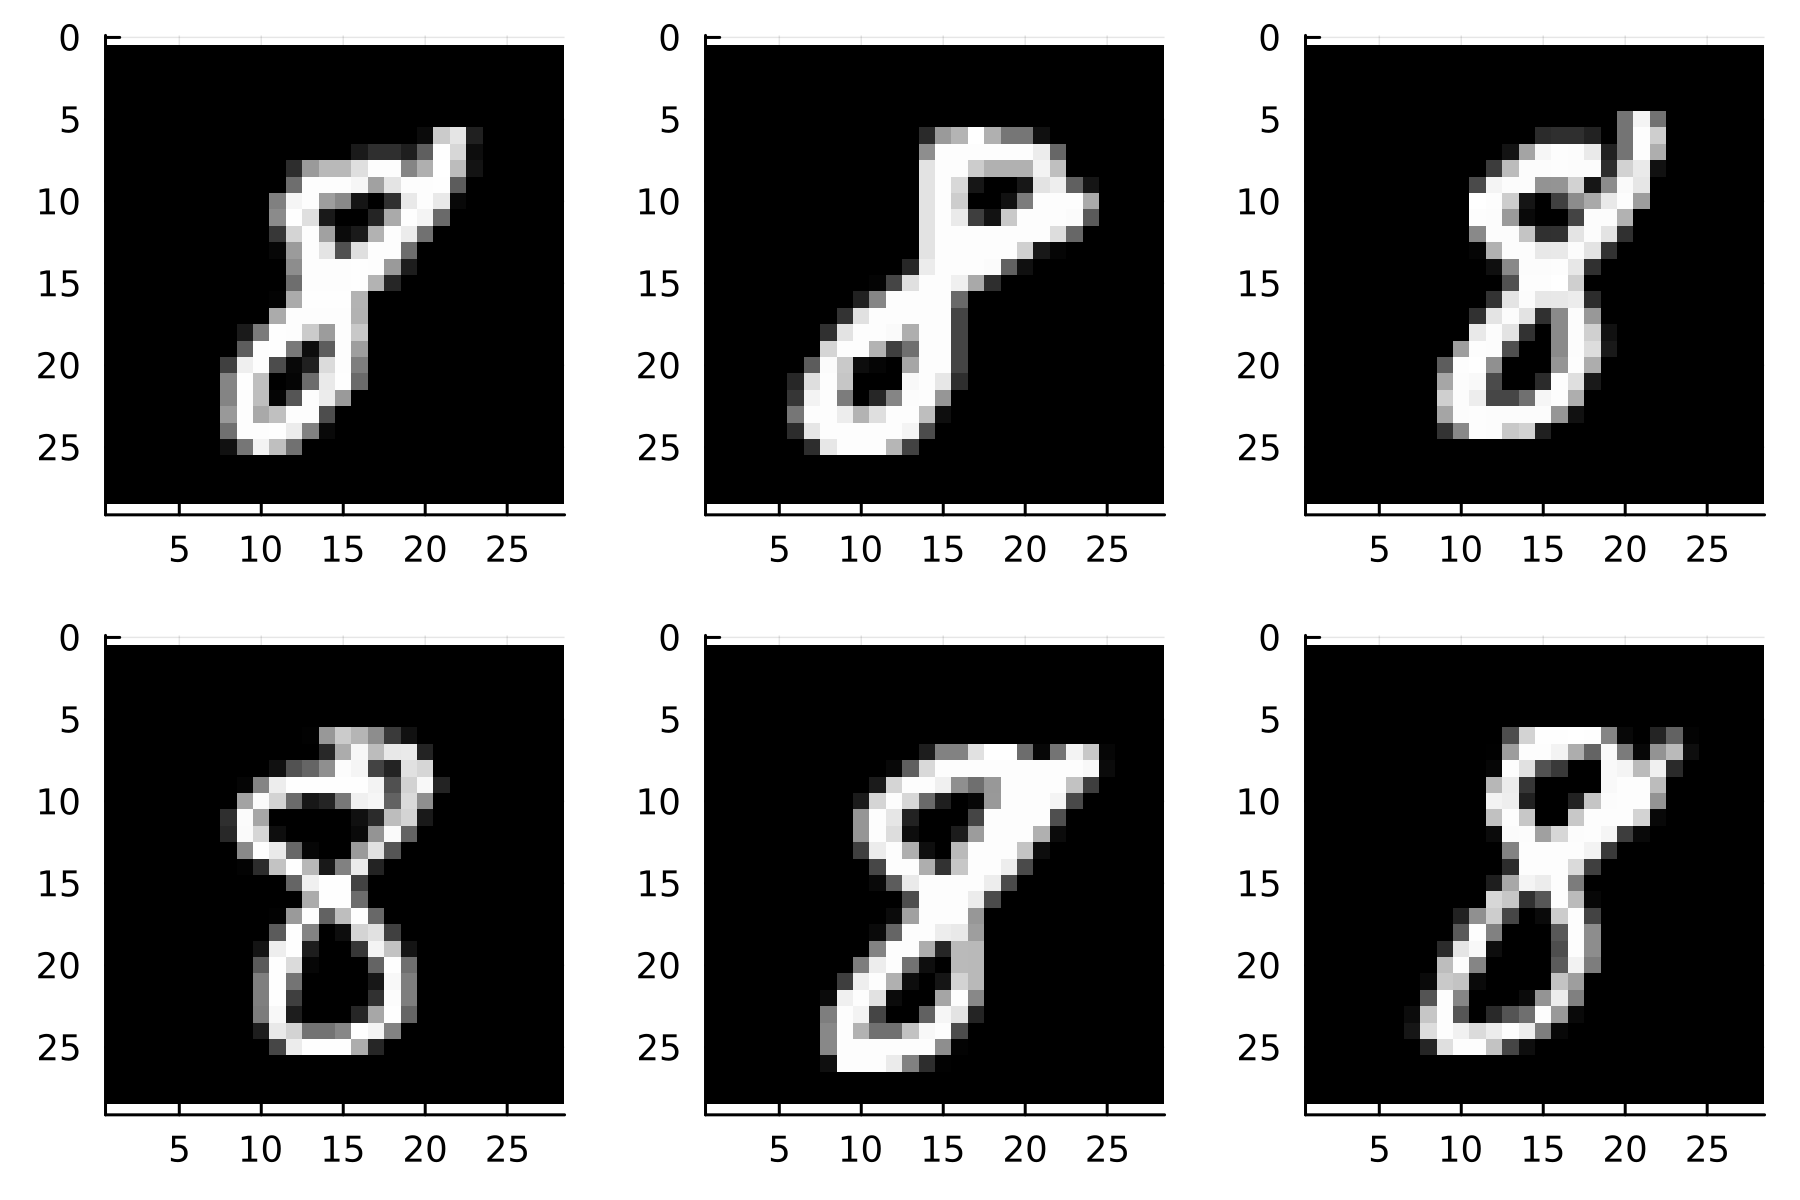

In [50]:
pred = findall(pred_clustering_1 .== (8 + 1))
plt = nothing
images = [plot(Gray.(reshape(train_x[:,pred[i]], 28, 28)')) for i=1:6]
plot(images...)